# Maximum Liklihood Estimation

Taken from [Alejandro Morales](https://alemorales.info/post/mle-nonlinear/)

Maximum liklihood estimation (MLE) is a method to estimate the parameteres of a random population given a sample. To understand MLE we first need to understand the difference between probability and probability density for continuous variables. 

Probability is the intergral of probability density over some range. For example the bell shaped curve associated with the normal distribution is a measure of probability density, whereas probability corresponds to the area under the curve.

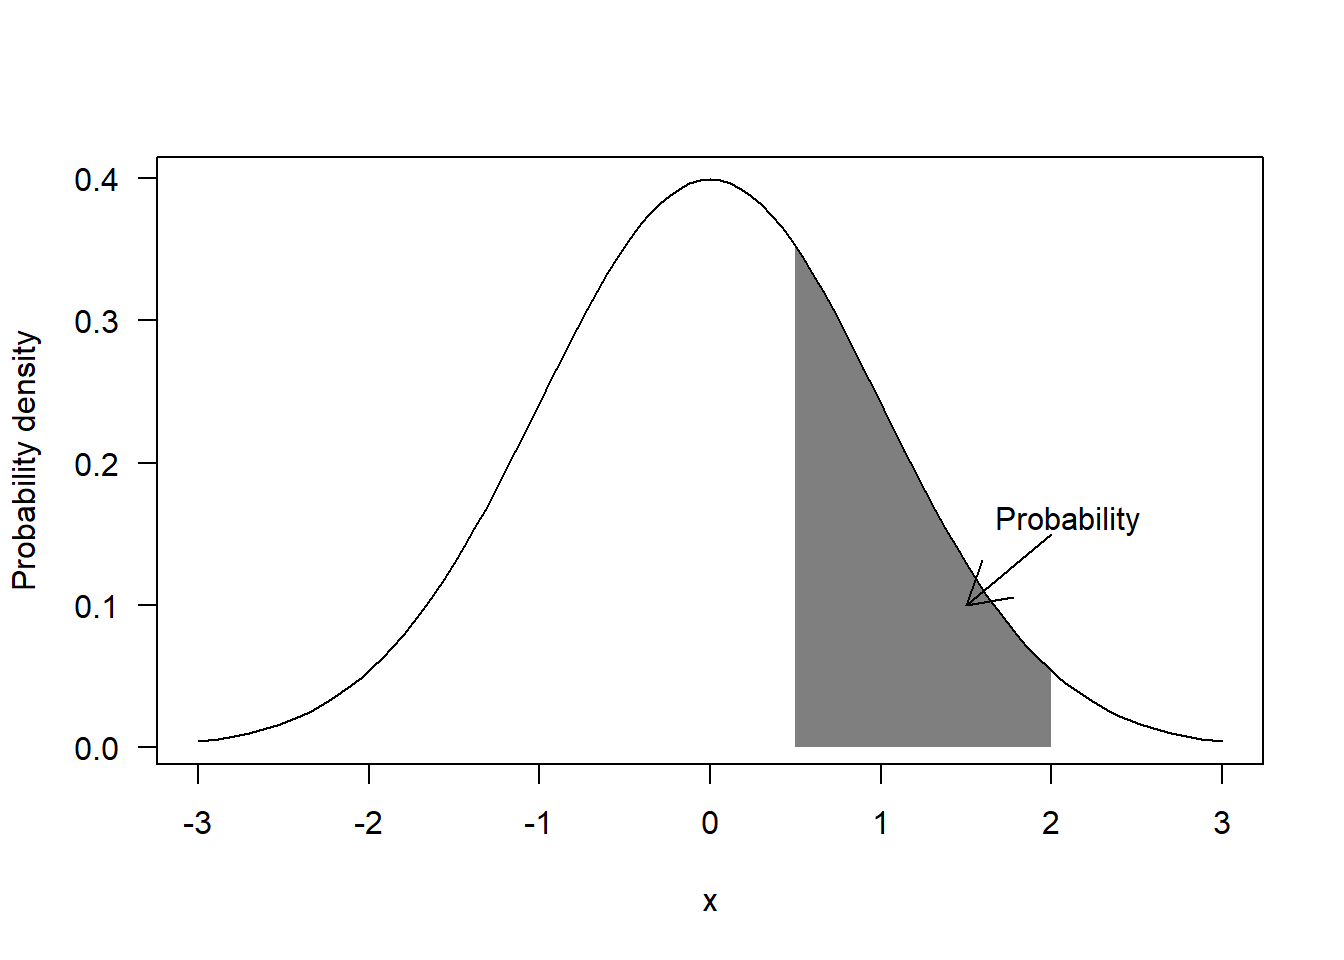

If we assign a statistical model to a random population, any particular value $x_i$ sampled from the population will have a probability density according to the model $f(x_i)$. If we then assume that all the values in our sample are statistically independent (i.e the probability of sampling a particualr value does not depend on the rest of the values already sampled), then the liklihood of observing the whole sample $L(x)$ is defined as the product of the probability densities of the individual values:

$$L(x) = \prod^n_{i=1}f(x_i)$$

For example, if we assume the data were sampled from a Normal distribution, the liklihood is defined as:

$$L(x) = \prod^n_{i=1}\frac{1}{\sqrt{2\pi\sigma^2}}\exp^{-\frac{(x_i - \mu)^2}{2\sigma^2}}$$

Note that $L(x)$ does not depend on $x$ only, but also on $\mu$ and $\sigma$, that is, the parameters in the statistical model describing the random population. The idea behind MLE is to find the values of the parameters in the statistical model that maximize $L(x)$. In other words, it calculates the random population that is most likely to generate the observed data, while being constrained to a particular type of distribution.


A complication of the MLE method is that, as probability densities are often smaller than 1, the value of $L(x)$ can become very small as the sample size grows. For example the lilihood of 100 values sampled from the Normal distribution is very small

In [3]:
from numpy import random, prod
from scipy.stats import norm

random.seed(2021)
sample = random.randn(100)
print("L(x): ", prod(norm.pdf(sample)))

L(x):  1.84053319547549e-63


As many of much of MLE relies on numerical optimisation methods these issues are of significant improtance. Hence, we cannot work directly with the liklihood function. 

### Log Trick
A commonly used trick is to use the natural logatihm of the liklihood function $\log(L(x))$. Using the logrithm enables us to convert the product into a sum.

$$\log(L(x))=\sum^n_{i=1}\log(f(x_i))$$

This mapping also scales the log-liklihood towards 1 whilst maintaining the maximal parameter value. For example, the liklihood of the first sample generated above, as a funciton of $\mu$ is

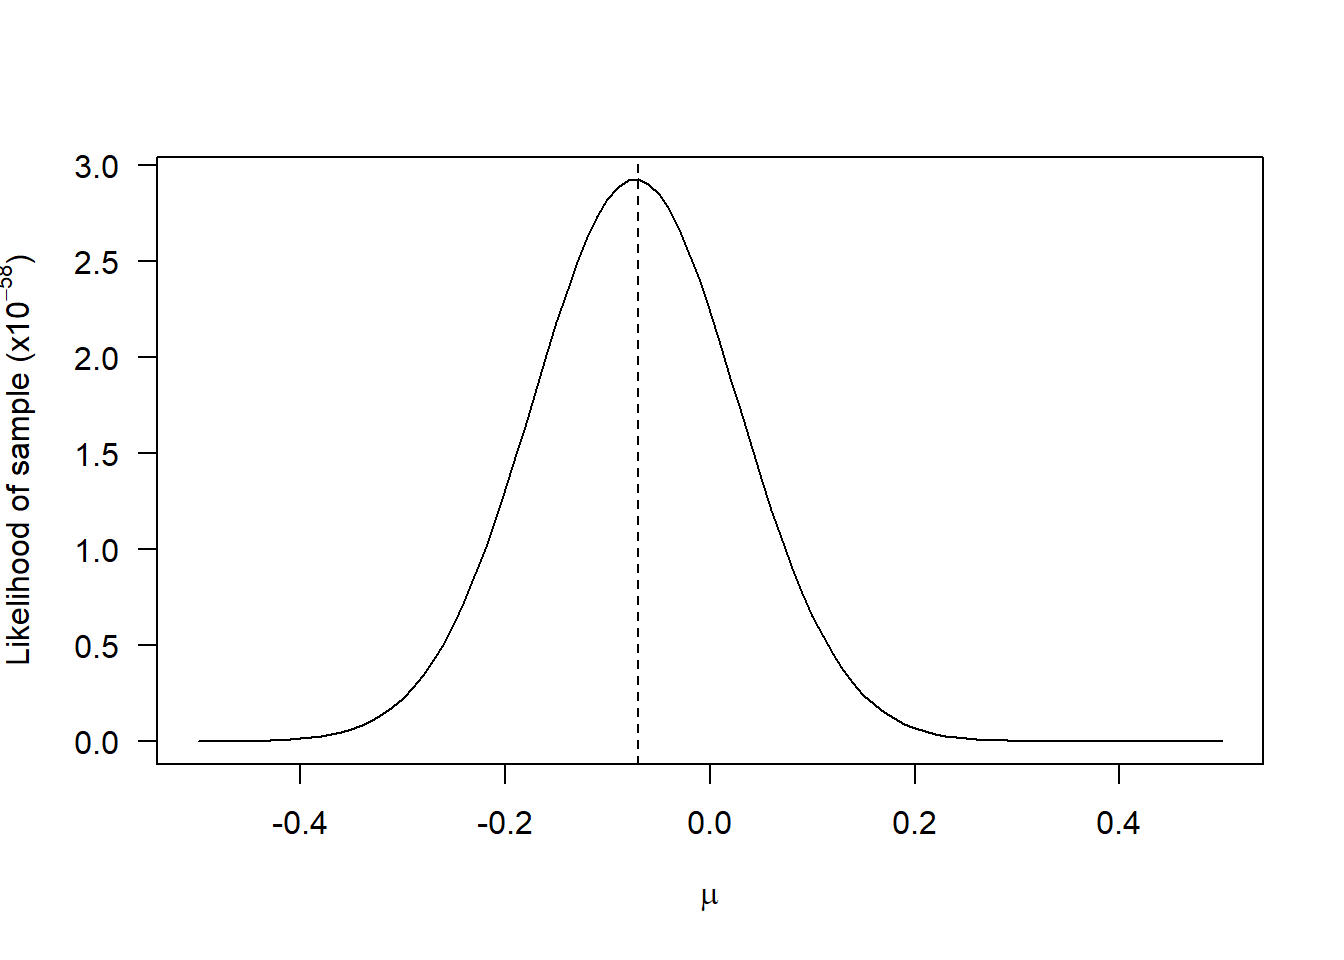

whereas for the log-likelihood it becomes

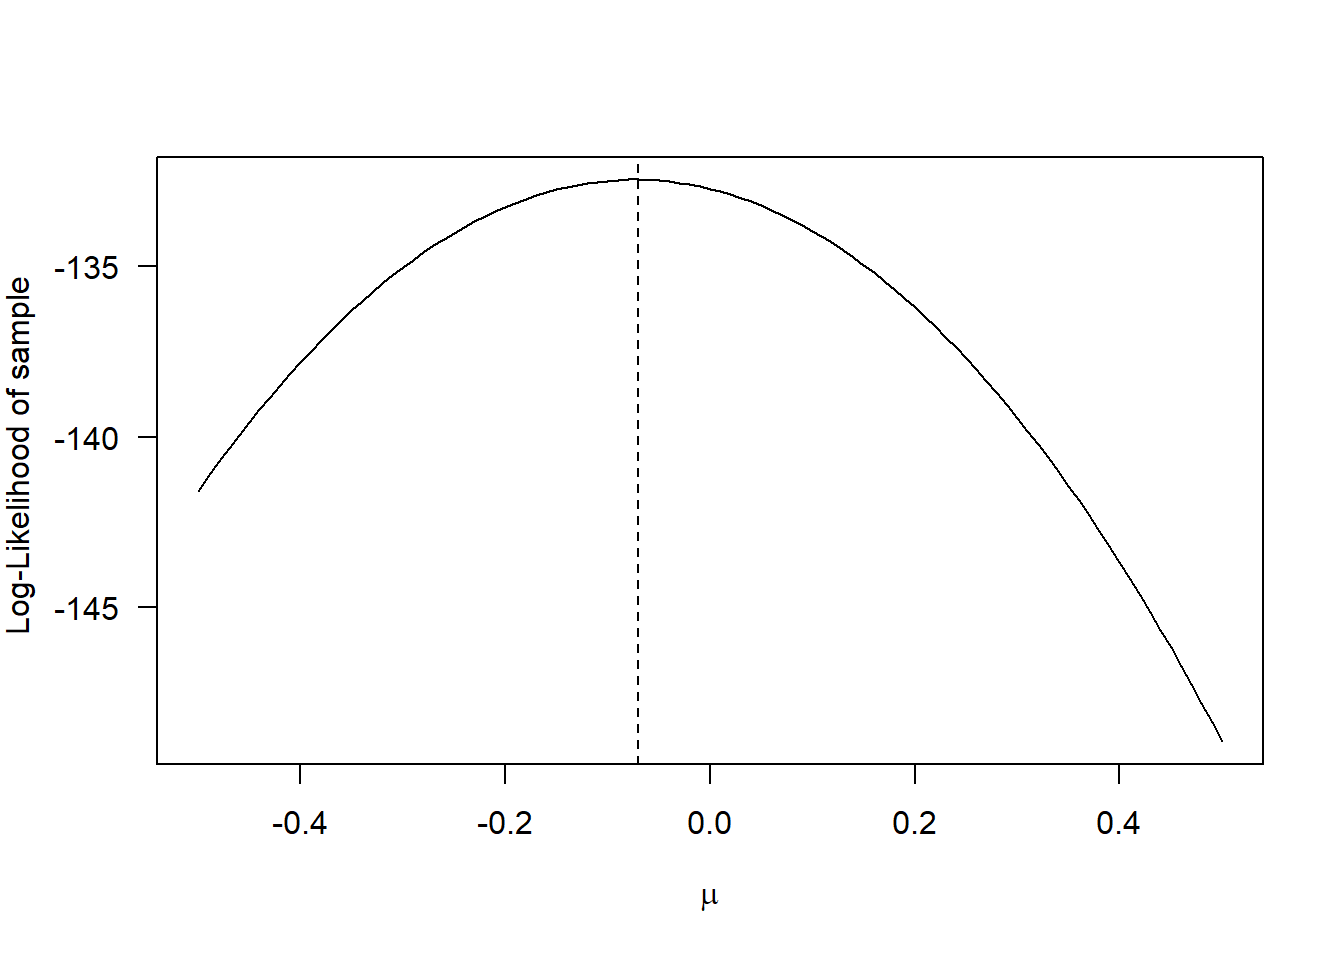

Although the shapes of the curves are different, the maximum occurs for the same value of $\mu$. Note that there is nothing special about the natural logarithm: we could have taken the logarithm with base 10 or any other base. But it is customary to use the natural logarithm as some important probability density functions are exponential functions (e.g. the Normal distribution, see above), so taking the natural logarithm makes mathematical analyses easier.

You may have noticed that the optimal value of $\mu$ was not exactly 0, even though the data was generated from a Normal distribution with $\mu = 0$. This is the reason why it is called a maximum likelihood estimator. The source of such deviation is that the sample is not a perfect representation of the population, precisely because of the randomness in the sampling procedure. A nice property of MLE is that, generally, the estimator will converge asymptotically to the true value in the population (i.e. as sample size grows, the difference between the estimate and the true value decreases).

The final technical detail you need to know is that, except for trivial models, the MLE method cannot be applied analytically. One option is to try a sequence of values and look for the one that yields maximum log-likelihood (this is known as grid approach as it is what I tried above). However, if there are many parameters to be estimated, this approach will be too inefficient. For example, if we only try 20 values per parameter and we have 5 parameters we will need to test 3.2 million combinations.


Instead, the MLE method is generally applied using algorithms known as non-linear optimizers. You can feed these algorithms any function that takes numbers as inputs and returns a number as ouput and they will calculate the input values that minimize or maximize the output. It really does not matter how complex or simple the function is, as they will treat it as a black box. By convention, non-linear optimizers will minimize the function and, in some cases, we do not have the option to tell them to maximize it. Therefore, the convention is to minimize the negative log-likelihood (NLL).

As an example of how NLL works, we first need to calculate NLL. A NLL funciton should take two inputs (i) A vector of parameter values that the optimisation wants to test `params` and (ii) the `data` for which the NLL is calculated. For the problem of estimating $\mu$ and $\sigma$, the function looks like this


In [22]:
from scipy.stats import norm

random.seed(2021)
sample = random.randn(1000)

def NLL(params, data=sample):
    mu = params[0]
    sigma = params[1]
    
    # Calculate negative log liklihood
    return -sum(norm.logpdf(data, loc=mu, scale=sigma))

NLL([0,1], sample)

1425.7633698265433

The function `norm.logpdf` returns the logarithm of the probability density of the data assuing a Normal distribution with given mean and standard deviation (`mean` and `sd`). Then we just add up all these values (that yeilds the log liklihood as shown before) and switch the sign to get the NLL.

We can now minimise the NLL using the funciton `minimise`. The `scipy.optimize` function. There are many optimisation functions that can be used. In the following example we have used the `Nelder-Mead` method with a `tol=1e-8`. More details of the package can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize).


In [23]:
from scipy.optimize import minimize
import numpy as np

x0 = np.array([0.2, 1.5])
res = minimize(NLL, x0, method='nelder-mead',
               tol=1e-8, options={'disp': True})

print("Result: ", res.x)

Optimization terminated successfully.
         Current function value: 1425.717207
         Iterations: 71
         Function evaluations: 141
Result:  [8.90188904e-05 1.00680170e+00]
